# Publicaciones candidatas a ser integradas al Repositorio Institucional

Esta notebook tiene como objetivo identificar y caracterizar las publicaciones provenientes de OpenAlex que aún no forman parte del Repositorio Institucional (IR).

A partir de los datos integrados en el Data Vault, se busca:
- Detectar publicaciones con autores institucionales que no están en el IR.
- Evaluar su accesibilidad (abiertas vs. cerradas).
- Medir su impacto potencial (citas, posición en percentiles).
- Explorar posibilidades de integración, especialmente de aquellas en acceso abierto, conforme a la Ley Nacional de Acceso Abierto (26.899).

El análisis parte de una tabla enriquecida con metadatos de OpenAlex y se cruza con el IR a partir del DOI.


### Procesamiento de datos

##### Imports y configuración inicial

In [18]:
import pandas as pd

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 5)

import seaborn as sns
import matplotlib.pyplot as plt



#### Carga de datos


##### OpenAlex

Se cargan los datos:
* Hub de Works
* Hub de DOI
* Links entre Work y DOI
* Satélites de Work

In [19]:
hub_openalex_work = catalog.load('stg_openalex/hub_openalex_work')
hub_openalex_doi = catalog.load('stg_openalex/hub_openalex_doi')
link_openalex_work_doi = catalog.load('stg_openalex/link_openalex_work_doi')
sat_openalex_work = catalog.load('stg_openalex/sat_openalex_work')


[05/09/25 11:04:40] INFO     Loading data from stg_openalex/hub_openalex_work                   ]8;id=609853;file:///home/pablo/.local/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=949328;file:///home/pablo/.local/lib/python3.10/site-packages/kedro/io/data_catalog.py#389\389]8;;\
                             (SQLTableDataset)...                                                                  

[05/09/25 11:04:41] INFO     Loading data from stg_openalex/hub_openalex_doi                    ]8;id=401147;file:///home/pablo/.local/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=103777;file:///home/pablo/.local/lib/python3.10/site-packages/kedro/io/data_catalog.py#389\389]8;;\
                             (SQLTableDataset)...                                                                  

                    INFO     Loading data from stg_openalex/link_openalex_work_doi              ]8;id=363451;file:///home/pablo/.local/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=293344;file:///home/pablo/.local/lib/python3.10/site-packages/kedro/io/data_catalog.py#389\389]8;;\
                             (SQLTableDataset)...                                                                  

[05/09/25 11:04:42] INFO     Loading data from stg_openalex/sat_openalex_work                   ]8;id=494574;file:///home/pablo/.local/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=198727;file:///home/pablo/.local/lib/python3.10/site-packages/kedro/io/data_catalog.py#389\389]8;;\
                             (SQLTableDataset)...                                                                  

##### IR

Se cargan los datos del Hub de DOI

In [20]:
hub_dspace5_doi = catalog.load('stg_dspace5/hub_dspace5_doi')


[05/09/25 11:04:46] INFO     Loading data from stg_dspace5/hub_dspace5_doi (SQLTableDataset)... ]8;id=173620;file:///home/pablo/.local/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=261746;file:///home/pablo/.local/lib/python3.10/site-packages/kedro/io/data_catalog.py#389\389]8;;\

#### Integración de datos 

Armo un df con los work de OpenAlex con doi en *df_openalex*.

In [21]:
df_openalex = pd.merge(
    hub_openalex_work,
    link_openalex_work_doi
)

df_openalex = pd.merge(
    df_openalex,
    hub_openalex_doi
)

df_openalex = pd.merge(
    df_openalex,
    sat_openalex_work
)

df_openalex[['work_id','doi','title','type','language','has_fulltext','is_retracted','publication_date','oa_status','oa_url','any_repository_has_fulltext','is_oa']]

,work_id,doi,title,type,language,has_fulltext,is_retracted,publication_date,oa_status,oa_url,any_repository_has_fulltext,is_oa
0,https://openalex.org/W3017375070,10.37603/2250.7728.v24.n1.28239,Potrero de Garay y el espacio habitacional pre...,article,es,True,False,2020-04-17 21:00:00,closed,https://dialnet.unirioja.es/descarga/articulo/...,True,False
1,https://openalex.org/W3031656744,10.24215/16696581e278,Impacto de la pandemia por COVID-19 en la salu...,article,NO DATA,True,False,2020-05-14 21:00:00,diamond,https://perio.unlp.edu.ar/ojs/index.php/questi...,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...
39568,https://openalex.org/W3196308089,10.25260/ea.21.31.3.0.1508,Circulación de virus ARN entre diversas especi...,article,en,True,False,2021-10-03 21:00:00,diamond,https://ojs.ecologiaaustral.com.ar/index.php/E...,False,True
39569,https://openalex.org/W2942219882,10.5380/jlasss.v9i1.61189,Los debates de la educación física y los enfoq...,article,es,False,False,2018-09-02 21:00:00,closed,NO DATA,False,False


Join con los DOI del repositorio

In [22]:
df_publications = pd.merge(
    df_openalex,
    hub_dspace5_doi,
    on='doi',
    how='left',
    suffixes=('_openalex', '_dspace')
)

In [23]:
df_publications[['work_id', 'doi', 'doi_hk_dspace']]

,work_id,doi,doi_hk_dspace
0,https://openalex.org/W3017375070,10.37603/2250.7728.v24.n1.28239,NaN
1,https://openalex.org/W3031656744,10.24215/16696581e278,b'\xf9\x178\xe5Gb\xd2#=U\x9e\xc0\xd73\x82$'
...,...,...,...
39568,https://openalex.org/W3196308089,10.25260/ea.21.31.3.0.1508,NaN
39569,https://openalex.org/W2942219882,10.5380/jlasss.v9i1.61189,NaN


### Identificación de publicaciones no integradas al IR

In [ ]:
filter_publication = df_publications['doi_hk_dspace'].isna()
df_candidates = df_publications[filter_publication]

In [11]:
df_candidates['is_oa'].value_counts(dropna=False)


is_oa
True     13317
False    12574
Name: count, dtype: int64

In [ ]:
df_candidates['is_oa'].value_counts(normalize=True, dropna=False) * 100


is_oa
True     51.434862
False    48.565138
Name: proportion, dtype: float64

Conteos verificados:
is_oa
True     13317
False    12574
Name: count, dtype: int64


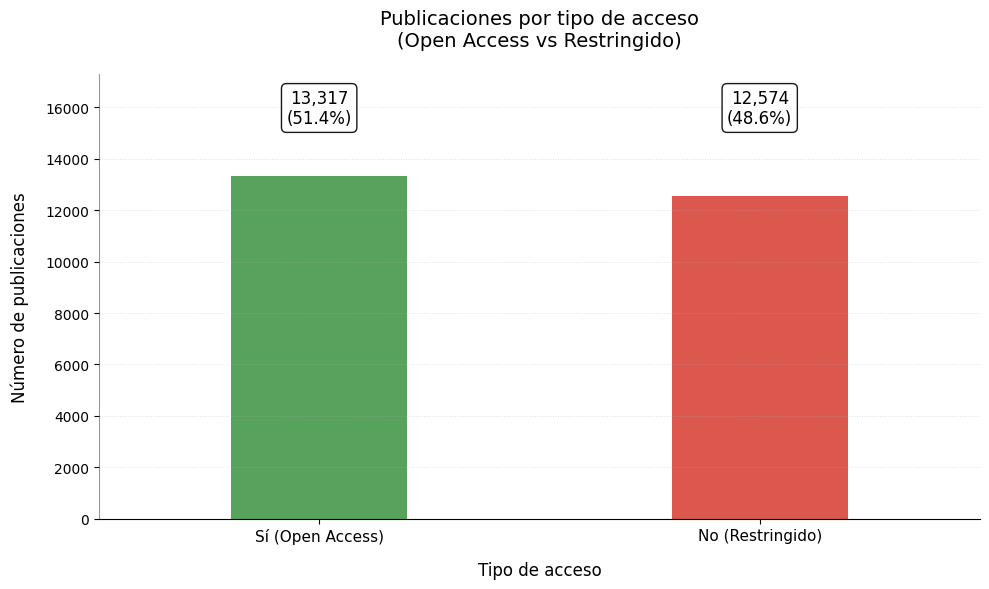

In [38]:
# Verificación de datos (opcional, para confirmar)
print("Conteos verificados:")
print(df_candidates['is_oa'].value_counts().reindex([True, False]))

# Configuración del gráfico
plt.figure(figsize=(10, 6))
colors = ['#F44336','#4CAF50']  # Verde para Open Access

# Gráfico corregido (sin warnings)
ax = sns.barplot(x=counts.index, y=counts.values, hue=counts.index, 
                 palette=colors, width=0.4, order=[True, False],
                 legend=False, dodge=False)  # Corrección del warning

# Personalización avanzada
plt.title('Publicaciones por tipo de acceso\n(Open Access vs Restringido)', 
          fontsize=14, pad=20)
plt.xlabel('Tipo de acceso', labelpad=12, fontsize=12)
plt.ylabel('Número de publicaciones', labelpad=12, fontsize=12)
plt.xticks(ticks=[0, 1], labels=['Sí (Open Access)', 'No (Restringido)'], fontsize=11)

# Altura uniforme para textos (20% sobre el máximo)
text_height = max(counts.values) * 1.20

# Etiquetas mejoradas
for i, (v, p) in enumerate(zip(counts.values, percentages)):
    ax.text(i, text_height, f"{v:,}\n({p:.1f}%)", 
            ha='center', va='center', fontsize=12,
            bbox=dict(facecolor='white', alpha=0.9, boxstyle='round,pad=0.3'))

# Estilo profesional
ax.yaxis.grid(True, linestyle=':', linewidth=0.7, alpha=0.4)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_alpha(0.4)

plt.ylim(0, max(counts.values)*1.3)
plt.tight_layout()
plt.show()